# Matrices OCR training

This tutorial shows how you can train the OCR module of the [Matrices repository](https://github.com/merialdo/research.matrices) in your Google Colab.



## 1 Disclaimer

This colab loads and saves data from/into your Google Drive main folder.

Please make sure that you have your dataset in your Google Drive main folder (in HDF5 format).

When this Colab will ask you permission to access your Google Drive data, answer "consent".

The training output (e.g., summary files and checkpoints of the training process) and any evaluation result files will be saved in a new folder created on your Google Drive main folder, with the same name as your dataset (but without the HDF5 extension).

## 2 Parameters

In this Python cell we define the main parameters of the training process.

In [ ]:
import string 

source = "onorio_newnew"           # name of the dataset to use and of the model to create.
dataset_name = source + ".hdf5"    # complete name of the dataset
epochs = 100                       # number of training epochs
batch_size = 16                    # number of samples per mini-batch
learning_rate=0.001                # learning rate of the training process

#input_size = (1024, 128, 1)       # input size of the images to transcribe 
input_size = (640, 64, 1)

#max_text_length = 128             # max number of characters for each transcribed line
max_text_length = 180

validation_interval = 1            # number of training epochs between validations

charset_base = string.printable[:95]#+"€"     # alphabet of available characters

## 3 Google Colab Environment


### 3.1 TensorFlow 2.x

Make sure the jupyter notebook is using GPU mode.

In [ ]:
!nvidia-smi

Thu Jan 13 17:39:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |  14690MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install TensorFlow 2.x., and verify it has been installed correctly.

In [ ]:
#!pip install -q tensorflow-gpu

%tensorflow_version 2.x

import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"Found GPU at: {device_name}")

### 3.2 Google Drive

Mount your Google Drive partition; after this step, you should be able to see the list of your Google Drive files in the project folder, under path /content/drive.

Note: the project folder is temporary storage exclusive to this Colab notebook, and it is now only partially connected to your Google Drive. So: 
- interacting with files in /content/drive actively changes the content of your Google Drive
- but any changes to other paths in the project folder will likely be erased reloading the notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### 3.3 Clone the Matrices Repository from GitHub

Clone the research.matrices repository into the project folder in path /content/matrices.

In [ ]:
import os
import shutil

if os.path.isdir("matrices"):
  shutil.rmtree("matrices")
os.mkdir("matrices")

!git clone https://github.com/merialdo/research.matrices matrices

Cloning into 'matrices'...
remote: Enumerating objects: 410, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 410 (delta 80), reused 134 (delta 58), pack-reused 231
Receiving objects: 100% (410/410), 8.47 MiB | 21.57 MiB/s, done.
Resolving deltas: 100% (151/151), done.


Install the backend requirements for Matrices:

In [ ]:
!pip install -r /content/matrices/backend/requirements.txt

Create a "data" folder in the matrices project and copy the dataset from Google Drive to that folder

In [ ]:
matrices_data_folder = "/content/matrices/data"

# define paths
dataset_path = os.path.join(matrices_data_folder, dataset_name)
output_path = os.path.join("/content/drive/MyDrive", source)
checkpoint_path = os.path.join(output_path, "checkpoint_model.{epoch:02d}.hdf5")

os.makedirs(output_path, exist_ok=True)

In [ ]:
if os.path.isdir(matrices_data_folder):
  shutil.rmtree(matrices_data_folder)
os.mkdir(matrices_data_folder)

shutil.copyfile(os.path.join("/content/drive/MyDrive", dataset_name), os.path.join(matrices_data_folder, dataset_name))

## 4 Run the Training Process

Move to the Matrices folder and perform the actual training process.
At constant intervals defined in the validation_interval parameters, a validation run will be executed on the validation set; if the model loss on the validation set has improved since the last validation run, the checkpoint of the current epoch will be saved on Google Drive.

The training process keeps track of which epoch has been the "best" one in terms of validation loss.

In [ ]:
%cd '/content/matrices/'

import sys
sys.path.insert(0,"/content/matrices/backend/ocr_service/")

from backend.ocr_service.model import HTRModel
import backend.ocr_service.evaluation as evaluation
from backend.ocr_service.dataset import HDF5Dataset

import time
import logging
import datetime

try:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
    logging.disable(logging.WARNING)
except AttributeError:
    pass

device_name = tf.test.gpu_device_name()

print("Dataset: ", dataset_path)
print("Output model folder: ", output_path)

# load the dataset to use in training, validation and testing
dataset = HDF5Dataset(source_path=dataset_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)
print(f"Train images:      {dataset.training_set_size}")
print(f"Validation images: {dataset.valid_set_size }")
print(f"Test images:       {dataset.test_set_size}")

# create and compile HTRModel
htr_model = HTRModel(input_size=input_size,
                     vocabulary_size=dataset.tokenizer.vocab_size,
                     beam_width=10,
                     stop_tolerance=25,
                     reduce_tolerance=20)

htr_model.compile(learning_rate=learning_rate)
htr_model.summary(output_path, "summary.txt")

# ???
resumed_model = ''
htr_model.load_checkpoint(target=resumed_model)
callbacks = htr_model.get_callbacks(logdir=output_path,
                                    checkpoint=checkpoint_path,
                                    verbose=1)

# to calculate total and average time per epoch
start_time = datetime.datetime.now()


htr_model_history = htr_model.fit(x=dataset.training_data_generator,
                                  epochs=epochs,
                                  validation_data=dataset.valid_data_generator,
                                  validation_freq=validation_interval,
                                  callbacks=callbacks,
                                  verbose=1)

training_time = datetime.datetime.now() - start_time

loss = htr_model_history.history['loss']
val_loss = htr_model_history.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

avg_epoch_time = (training_time / len(loss))
best_epoch = (min_val_loss_i + 1) * validation_interval

t_corpus = "\n".join([
    f"Total validation images: {dataset.valid_data_generator}",
    f"Batch Size:              {dataset.training_data_generator.batch_size}\n",
    f"Total Training Time:     {training_time}",
    f"Time per epoch:          {avg_epoch_time}",
    f"Total epochs:            {len(loss)}",
    f"Best epoch:              {best_epoch}",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])


with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)
  
print("The best epoch for validation loss has been Epoch " + str(best_epoch))

/content/matrices


Run evaluation on the test set, and extract
- global metrics:
 - Character Error Rate
 - Word Error Rate
 - Sequence Error Rate

- A visual representation of line image, original text and obtained transcription for each sample in the test set. 

Model Predict
1/1 [==============================] - 2s 2s/step
predict time 0:00:02.285116
CTC Decode
CTC Decode time 0:00:08.206408
--- 12.734134912490845 seconds ---
150 150 150
Metrics:
Character Error Rate: 0.08734811
Word Error Rate:      0.32537467
Sequence Error Rate:  0.99333333



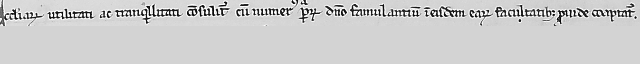

Ecclesiarum utilitati ac tranquillitati consulitur cum numerus personarum domino famulantium in eisdem earum facultatibus provide coaptatur
oeceiarum utilitati ac tranquilitati consilitur cum numerius peri domno famulantium in essdem earum facultatibus provide coaptantr



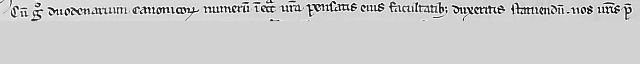

Cum ergo duodenarium canonicorum numerum in ecclesia vestra pensatis eius facultatibus duxeritis statuendum nos vestris pre
 Cum ergo duodenarium Canonicorum numerum in ecclesia vestra ponsatis evus facultatibus duxeritis statuendum vos vestrs pre



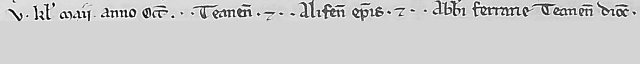

V. Kalendas Maii anno Octavo Teanensis et Alifensis episcopis et Abbati ferrarie Teanensis diocesis
 Kalendas Maij Anno Onctu Teanensus et Alifense episcopis et Abbati ferrarie Teanensis diocesis



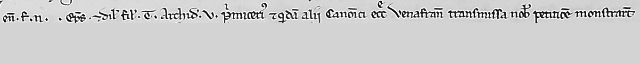

Venerabilis frater noster. Episcopus et dilecti filii .T. Archidiaconus .V. Primicerius et quidam alii canonici ecclesie Venafranensis transmissa nobis petitone monstrarunt
ense fratem nostrum Cpaoao  dilectus filius eterm Archidiacono Ve primicerius et quodam alij Canonici ecclesie Venafrani transmissa nobis petitione monstrant



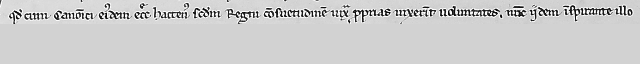

quod cum canonici eiusdem ecclesie hactenus secundum Regni consuetudinem iuxta proprias vixerint voluntates nunc iidem inspirante illo
quod cum Canonici eiusdem ecclesie hactenus sedum Regui consuetudinem iutr proprtas iuxerint voluntates nustre idem in spirante illo



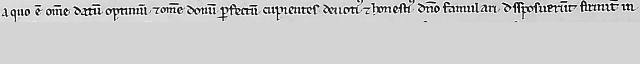

a quo est omne datum optimum et omne donum perfectum cupientes devotius et honestius domino famulari dssposuerunt firmiter in
a quo est omne datum optimum et omne donum perfectum cupientes devotius et honesius domino famulari disposuerunt firmiter in



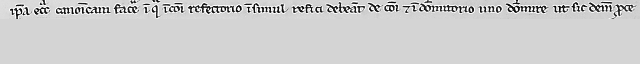

ipsa ecclesia canonicam facere in qua in communi refectorio insimul refici debeant de communi et in dormitorio uno dormire ut sic denim proce
ipsa ecclesie canonicam facem in que in comi refectorio insinui refici debeant de coni et in domitorio uno donire ut sic deie peroce



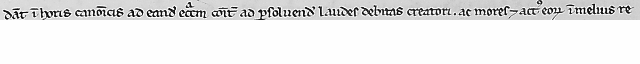

dant in horis canonicis ad eandem ecclesiam communiter ad persolvendas laudes debitas creatori ac mores et actus eorum in melius re
datm in horis canonicis ad eanem ecclsiam coitur ad persolvenem laudes debitas creatori ac mores et actus eorum in mnelius re



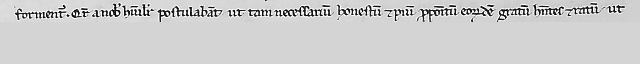

formentur Quare a nobis humiliter postulabant ut tam necessarium honestum et pium proponitum eorumdem gratum habentes et ratum ut
formentur cater anhbis humiliter postulabant ut tam necessarium honestum et pium propositum eorundem gratum habentes et ratum ut



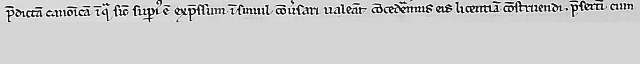

praedictam canonicam in qua sicut superius est expraessum insimul conversari valeant concederemus eis licentiam construendi praesertim cum
predictam canonicam in que sicut superus est expressum insimul conversari valeat concedemus es licentiam construendi presertum cum



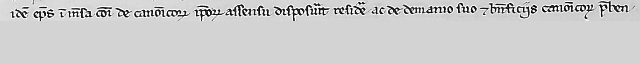

idem episcopus in mensa communi de canonicorum ipsorum assensu disposuerit residere ac de demanio suo et beneficiis canonicorum praeben
idem episcopus in venesa communi de canonicorum ipsorum assensu disposurint reside ac de demanio suo et beeficijs canonicorum preben



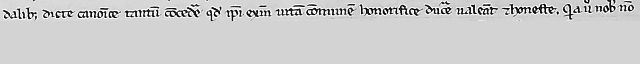

dalibus dicte canonice tantum concedere quod ipsi exinde vitam communem honorifice ducere valeant et honeste quia vero nobis non
Dalibus dicte canonice tantum concederem quod ipsi exinde vitam communem honorifice dioce valeant et honeste quia no nobis non



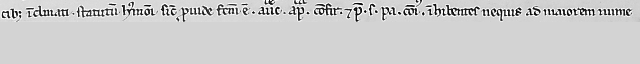

cibus inclinati statutum huiusmodi sicut provide factum est auctoritate apostolica confirmamus et praesentis scripti patrocinio communimus inhibentes ne quis ad maiorem nume
cibus inclinati statutum huiusmodi sicut provide factem est auctoritate apostolica confirmamum et presentis scpti ipatrocinio communuminhibentes nequis ad maiorem nume



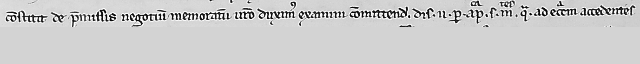

constitit de praemissis negotium memoratum vestro duximus examini committendum discretione vestra per apostolica scripta mandantes qua ad ecclesiam accedentes
constitit de premissis negotium memoratum vestro duximus examini committendem discretioni vestre per apostolica scripia mandames qa ad ecclesim accedentes



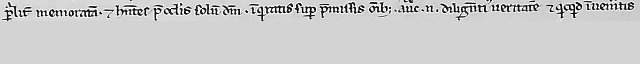

personaliter memoratam et habentes prae oculis solum deum inquiratis super praemissis omnibus auctoritate nostra diligentius veritatem et quicquid inveneritis
perlipur memoratam et habentes pr eculis solum deum in quiratis super premsss omibus auctoritate nostra dilgntum veritate etn quis quid inveneitis



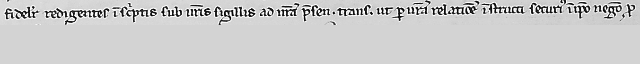

fideliter redigentes in scriptis sub vestris sigillis ad nostram praesentiam transmittittis ut per vestra relation instructi securius in ipso negotio pro
fideliter redigentes inscriptis sub vestris sigillis ad nostram presen trans ut per vestram relatione instructi securius in ipso negotio pro



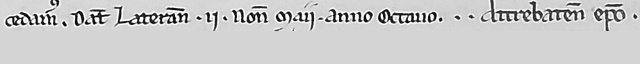

cedamus Datum Laterani .II. Nonas Maii Anno Octavo Attrebatensi episcopo
cedamus Datum Laterani II. Nonas Maij Anno Octavo Atrebatensi episcopo



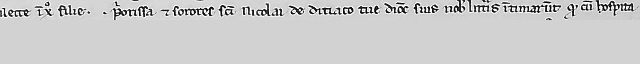

Dilecte in xristo filie piorissa et sorores sancti Nicolai de ditiaco tue diocesis suis nobis litteris intimarunt quod cum hospita
ilecte in Christo filie. prorissa et sorores sancti nicolai de ditiaco tue diocesis suis nobis litteris intimarunt quod cum hospita



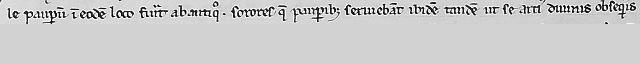

le pauperum in eodem loco fuerit ab antiquo sorores quae pauperibus serviebant ibidem tandem ut se artius divinis obsequiis
le pauperum in eodem loco fuerit ab antiquam sorores que pauperibus serviebant ibidem tandem ut se arius divinis obsepuijs



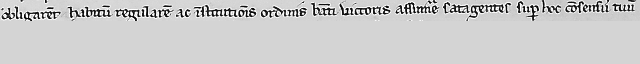

obligarent habitum regularem ac institutionis oridinis beati Victoris assumere satagentes super hoc consensum tuum
obligarent habitum regularem ac institutionis ordinis banti ictoris assumere satagentes super hoc consensum tuum



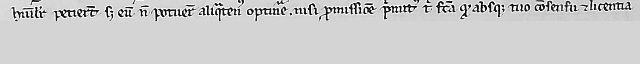

humiliter petierunt sed eum non potuerunt aliquatenus optinere nisi promissione primitus tibi facta quod absque tuo consensu et licentia
huiter petiernt sed eum non potuerit aliquatenus optinere nisi promissione premitus tibi facta qud absque tuo consensu et licentia



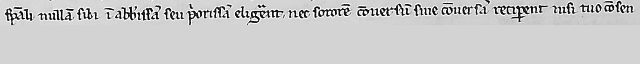

speciali nullam sibi in abbatissam seu priorissam eligerent nec sororem conversum sive conversam reciperent nisi tuo consen
speciali nullam sibi in abbissam seu prorissam eligerent nec sororem conversum sine conversam reciperent nisi tuo consen



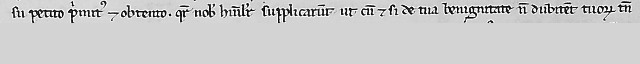

su petito primitus et obtento quare nobis humiliter supplicarunt ut cum et si de tua benignitate non dubitent tuorum tamen
su petito preimitus et obtento quaorde nobis humiliter supplicarunt ut cum et si de tua benigutate non dubitent tuorum tamen



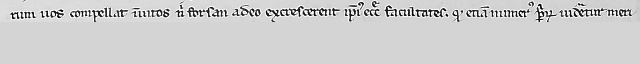

rum vos compellat invitos nisi forsan adeo excrescerent ipsius ecclesie facultates quod etiam numerus personarum videatur meri
rum vos compellat initos non forsan adeo excrescerent ipsius ecclesia facultates quod etiam munmerus peri videtur meri



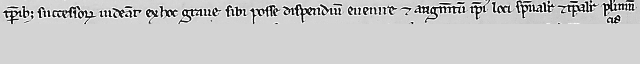

temporibus successorum videant ex hoc grave sibi posse dispendium evenire et augmentum ipsius loci spiritualiter et temporaliter plurimum
temporibus successorum videat ex hoc grave sibi posse dispendium evenire et angenentum ipsius loci spiritualiter et temporaliter Dunu



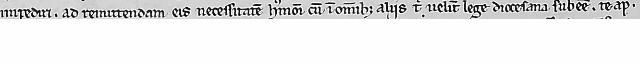

impediri ad remittendam eis necessitatem huiusmodi cum in omnibus aliis tibi velint lege diocesana subesse te apostolicis
impediri ad remitendam eis necessitatem huiusmodi cum in omnibus abijs tibi veliter legere diocesana subeseset te apostlice



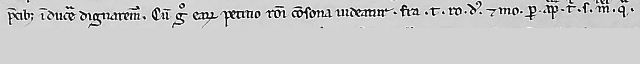

precibus inducere dignaremur Cum ergo earum petitio rationi consona videatur fratrem tuum rogandum duximus et monendum per apostolica tibi scripta mandantes qua
precibus induce dignaremus Cum ergo earum petito romi consona videatrur fratr tuus roado drituo et monendo per apostolica tibi scripta mandamus quatinus



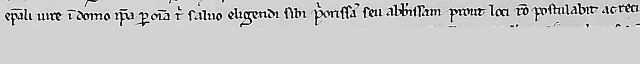

episcopali iure in domo ipsa per omnia tibi salvo eligendi sibi priorissam seu abbatissam prout loci ratio postulabit ac reci
episcopali ire in domo ipsa per omia tibi salvo eligendi sibi prorissam seu abbissam pronit loci ton postulabit ac reci



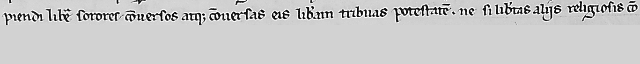

piendi libere sorores conversos atque conversas eis liberam tribuas potestatem ne si libertas aliis religiosis con
piendi libere sorores conversos atque conversas eis liberam tribuas potestatem ne si libertas abijs religiosis con



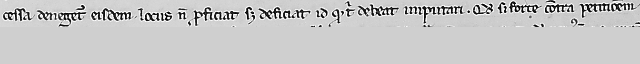

cessa denegetur eisdem locus non proficiat sed deficiat id quod tibi debeat imputari Quod si forte contra petitionem
cessa denegetur eisdem locus non proficiat sed deficiat id quod tibta debeat impurari Quod si forte contra petitionem



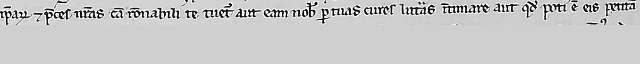

ipsarum et preces nostras causa rationabili te tuetur aut eam nobis per tuas cures litteras intimare aut quod potius est eis petitam
ipsarum et preces nostras causa ronabili te tuetur aut eam nobis per tuas cures litteras intimare aut quod potis est eis peitam



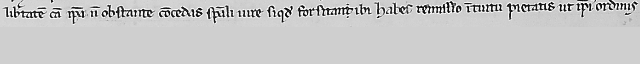

libertatem causa ipsa non obstante concedas speciali iure siquid forsitant ibi habes remissio intuito pietatis ut ipsius ordinis
libertatem causm ipsa non obstante concedas speciali iure si quiod forsitantabui habes remisso intutum pieratis ut ipsi ordinis



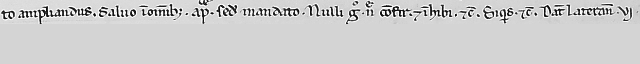

to ampliandus salvo in omnibus apostolice sedis mandato Nulli ergo ne confirmamus et inhibimus etcetera Si quis etcetera Datum Laterani .VI.
to ampliandus Salvo in omnibus apostolice sedis mandato Nulli ergo nosto confirmatiums et inhibi etcetera Siquis et etera Datum Laterani Vj



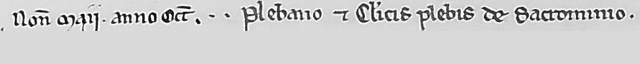

Nonas Maii anno Octavo Plebano et Clericis plebis de Sacrominio
Nonas Mqj Anno Octu Pebano i Eleicis plebis de Sacrominio



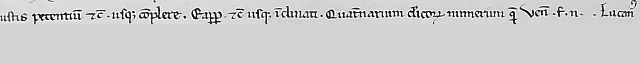

Iustis petentium etcetera usque complere Eapropter etcetera usque inclinati Quaternarium clericorum numerum quem venerabilis frater noster Lucanus
ustis peotentium etcetera usque complere Eaprer et ceta usque indlinati Quatimnarum clericorum mumerum quam Venerabilem fratem nosterum Laicamus



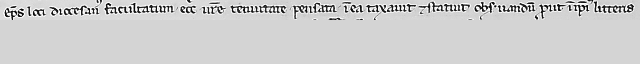

episcopus loci diocesanus facultatum ecclesiae vestre tenuitate pensata in ea taxavit et statuit observandum prout in ipsius litteris
epicopus loci diocesanus facultatum ecclesie vestre tenitate pensata in ea taxavit et statuit observandum prout in ipsius litteris



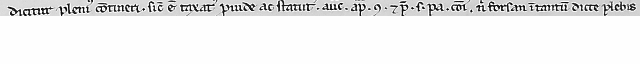

dicitur plenius contineri sicut est taxatus provide ac statutus auctoritate apostolica confirmamus et praesentis scripti patrocinio communimus nisi forsan in tantum dicte plebis
dicitur plenus contineri sicut est taxatut provide ac statut auctitate apostoliconcrimus et presentis scri patocinio comminim nont forsanm intantum dicte plebis



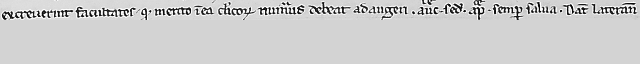

excreverint facultates quod merito in ea clericorum numerus debeat ad augeri auctoritate  sedis apostolice semper salva Datum Laterani
excreverint facultates quod merito in ea clericorum nuimus debeat ad augen auctoritate sede apostolica semper salva Datum lateranis



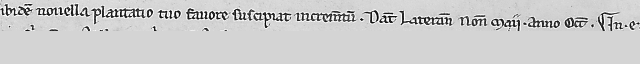

ibidem novella plantatio tuo favore suscipiat incrementum Datum Laterani Nonas Maij Anno Octavo Â§ In eodem
ibidem novella plantatio tuo favore suscipiat incrementum Datum Laterani nonas Maij Anno Oct qun eiam



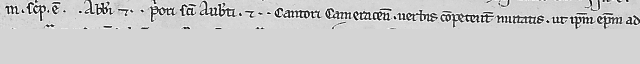

modo scriptum est Abbati et Priori sancti Auberti et Cantori Cameracensi verbis competenter mutatis ut ipsum episcopum ad
mo scriposesta Abbati et priori sancti Auberti et Cantori Cameracensis verbis competenter mitatis ut ipsus episcopum ad



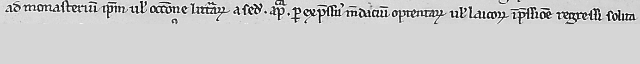

ad monasterium ipsum vel occasione litterarum a sede apostolica per expressum mendacium optentarum vel laicorum impressione regressi solita
ad monasterium ipsum vel occonoe litterarum a sedem apostolic per expressum indacium optentarum ullaicorum inprssione regressi solita



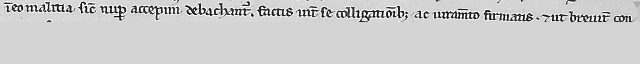

in eo malitia sicut nuper accepimus debachantur factis inter se colligationibus ac iuramento firmatis et ut breviter con
in eo malitia sicut nuper accepimus debachantur factis inter se colligationibus ac iuramento firmatis et ut breviter con



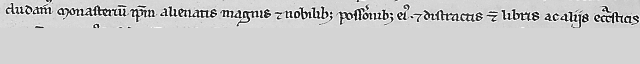

cludamus Monasterium ipsum alienatis magnis et nobilibus possessionibus eius et distractis etiam libris ac alijs ecclesiasticis
cdludamus Monasterium ipsum alienatis magnis et nobilibus possessionibus eius et distractis et libris ac alijs ecclesisticis



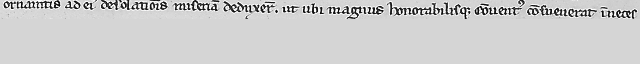

ornamentis ad eius desolationis miseriam deduxerit ut ubi magnus honorabilisque Conventus consueverat inneces
lornanintis ad eius desolationis miseriam dediuxerit ut ubi magnus honorabilisque Conventus consueverat innneces



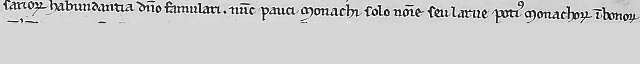

sariorum habundantia domino famulari nunc pauci Monachi solo nomine seu larve potius Monachorum in bonorum
sanorum habundantia domino famulari nuc pauci Monachi solo nomie seu larve potius Monachorum in honorum



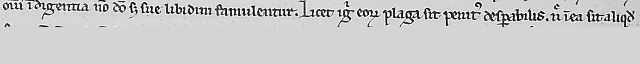

omnium indigentia non deo sed sue libidini famulentur Licet igitur eorum plaga sit penitus desperabilis nec in ea sit aliquod
Qouium indorgentia non deo sed sue libidium famulentur Licet igitur eorum plaga sit penvitus desperabilis vosr in ea si taliquod



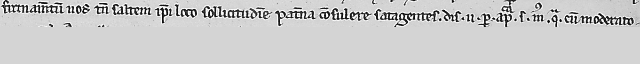

firmamentum vos tamen saltem ipsi loco sollicitudine paterna consulere satagentes discretioni vestre per apostolica scripta mandamus quatinus cum moderato
firmamentum vos tamen saltem ipsi loco sollicitudine paterna consulere satagentes discretioni vestre per apostolica scripia m ndaus qua cum moderato



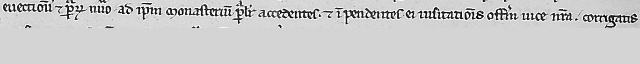

evectionum et personarum numero ad ipsum Monasterium personaliter accedentes et impendetes ei visitationis officium vice nostra corrigatis
evectioniust peru nuro ad ipsum Monasterium peribur accedentes et in pendentes ei visitationis offum vice nostra corrgatis



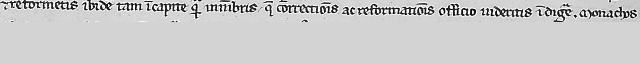

et reformetis ibidem tam in capite quam in membris que corrrectionis ac reformationis officio videritis indigere Monachos
etretormetis ibide tam in capite quo in mbris que corrrectionis ac reformationis officio videritis indigere Monachos



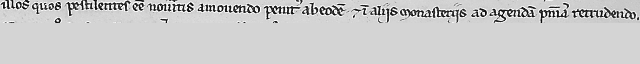

illos quos pestilentes esse noveritis amovendo penitus ab eodem et in alijs Monasterijs ad agendam penitentiam retrudendo
illos quos pestilentes esse novitis amovendo penitus ab eodem et in alijs Monasterijs ad agendam peniam retrudendo



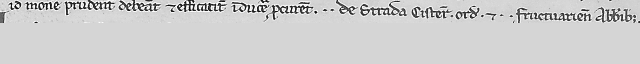

id monere prudenter debeant et efficaciter inducere procurent De Strada Cistercensis ordinis et Fructuariensibus Abbatibus
sod mone prudent debenat et efficatiter inducem procurent de Strada Cisteris ordinilis et fructuariensis Abbatibus



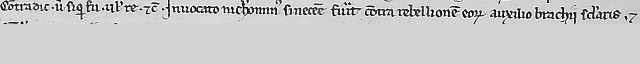

Contradictores vero siqui fuerint vel rebelles etcetera Invocato nichilominus si necesse fuerit contra rebellionm eorum auxilio brachij secularis et
contradict ven siqui fuu vil remo etctera Jnvocato nichilominus sineccese fuerit contra rebellionem eorum auxilio brachi selaris et



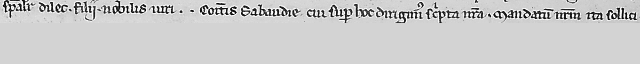

specialiter dilecti filij nobilis viri Comitis Sabaudie cui super hoc dirigimus scripta nostra Mandatum nostrum ita sollici
spirialiter dilectis filij nobilis viri Contis Saabaudie cui super hoc drigimus scripta nostra Mandatum nostrum ita sollici



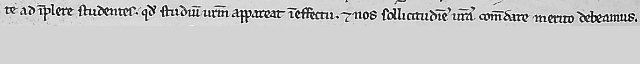

te ad implere studentes quod studium vestrum appareat in effectu et nos sollicitudinem vestram commendare merito debeamus
te ad implere studentes quod studium vestrnum appareat in effectu et nos sollicitudinem vestram comnedare merito debeamus



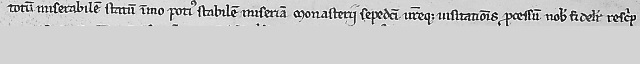

totum miserabilem statum immo potius stabilem miseriam Monasterij sepedicti vestreque visitationis processum nobis fideliter rescrip
totum miiserabilem statum imo potius stabilem miseriam Monasterij sepedicti vestreque iusitationis processum nobis fidelter resqrie



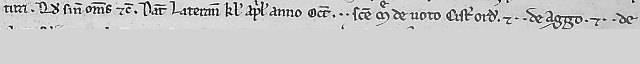

turi Quod si non omnes etcetera Datum Laterani Kalendas Aprilis Anno Octavo sancte Marie de voto Cistercensis ordinis et de Aggo et de
turi Duod si non omnes etcetera Datum Laterani Kalendas apsolus anno Oct sancte quuo de voto Cistetio ordinimus et de aggo et de



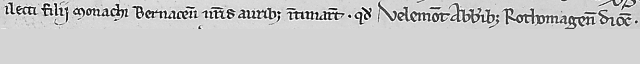

ilecti filij Monachi Bernacenses nostris auribus intimarunt quod Velemont Abbatibus Rothomagensis diocesis
ilecti filij Monachi Dernacensis nostris auribus intimarant quod Leelemont Abbatibus Rothomagensis dioceis



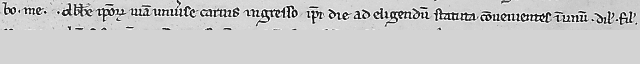

bone memorie Abbate ipsorum viam universe carnis ingresso ipsi die ad eligendum statuta convenientes in unum dilectum filium
boo me bbate ipsorum viam universe carus ingresso ipsi die ad eligendum statuta convenventes iniunum dilectus filius



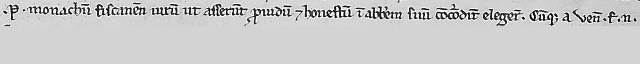

P monachum fiscanensem virum ut asserunt providum et honestum in abbatem suum concorditer elegerunt Cumque a Venerabili fratre nostro
P monachum fiscanensis virum ut asserunt providum et honestum in abbatem suum concorditer eligent Cumque a Venerbilem fratrem nostrem



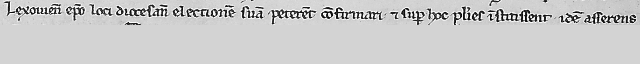

Lexoviensi episcopo loci diocesani electionem suam peterent confirmari et super hoc pluries institissent idem asserens
Lexovensem episcopo loci diocesani electionem suam peterent confirmari et super hoc plies institissent idem asserens



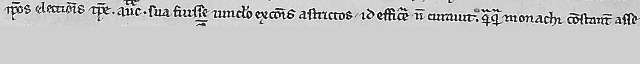

ipsos electionis tempore auctoritate sua fuisse vinculo excommunicationis astrictos id efficere non curavit quamquam monachi constanter asse
ipsos electionis tempore auctoritate sua fuissius inculo excommunicationi astrictos id effice non curavitus quaquam monachi constanter asse



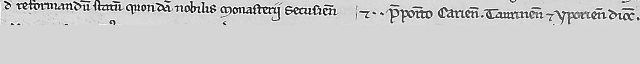

d reformandum statum quondam nobilis Monasterij Secusiensis  et Preposito Cariensi Taurinensis et Yporiensis diocesum
d reformandum stai quondam nobilis Monasterij Decusiensis et Preposito Cariensis Taurinensis et yporiensis diocesis



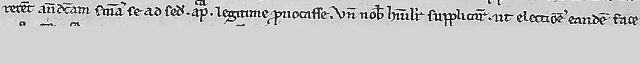

rerent antedictam sententiam se ad sedem apostolicam legitime provocasse Unde nobis humiliter supplicarunt ut electionem eandem face
rerent antedectam sententiam se ad sede apostolicm legitime provocasse Unde nobis humiliter supplicant ut electionem eandem face



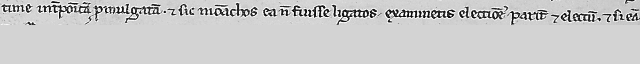

time interpositam promulgatam et sic monachos ea non fuisse ligatos examinetis electionem pariter et electum et si eam
tine interpositam promulgatam et sic monachos ea non fuisse ligatos examinetis electionem pariter et electum et si eauam



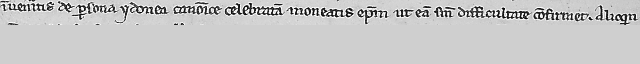

inveneitis de persona ydonea canonice celebratam moneatis episcopum ut eam sine difficultate confirmet Alioquin
invementis de persona jdonea canonice celebratam moneatis episcopum ut eam sien difficultate confirnet Alioquin



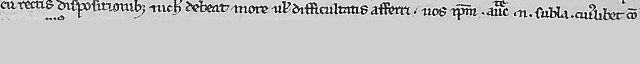

cum rectis dispositionibus nichil debeat more vel difficultatis afferri vos ipsum auctoritate nostra sublato cuiuslibet con
cu rectris dispositionibus nichis debeat more ve difficultatis afferri vos ipsum auctoritate nostra subla culsibet con



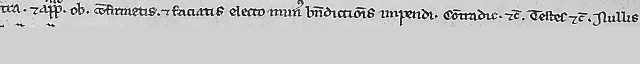

tradictionis et appellationis obstaculo confirmetis et faciatis electo munus benedictionis impendi Contradictores etcetera Testes etcetera Nullis
tra et appellationis obstaculo confirnetis et faciatis electo munus benedictionis impendi Cotradic etcetera Testes et cetera Nullis



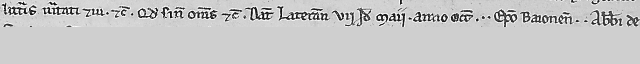

litteris veritati et iustitie etcetera Quod si non omnes etcetera Datum Laterani Vij Jdus Maij Anno Octavo Episcopo Baionensi Abbati de
litteris veritati etvio etcetera Quod si n omnes etcetera Datum Laterani Vij Idus Maij Anno Onceso Episcopo Baionensi Abbati de



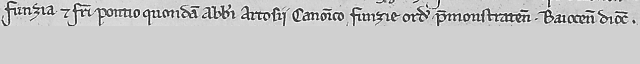

Funzia et fratri Pontio quondam Abbati Artosij Canonico Funzie ordinis premonstratensis Baiocensis diocesis
unia et fratri pontio quondam Abbati Artosij Canonico fungie ordninus premonstratensis Raocensis diocesis



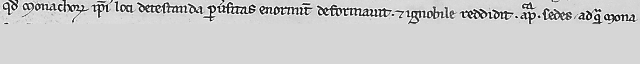

quod Monachorum ipsius loci detestanda perversitas enormiter deformavit et ignobile reddidit apostolica sedes ad quam Mona
quod Monachorum ipsius loci detestanda perversitas enormiter deformavit et ignobile reddidit apotolice sedes ad que Mona



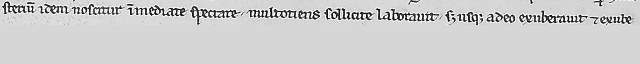

sterium idem noscitur immediate spectare multotiens sollicite laboravit sed usque ad eo exuberavit et exube
sterium idem noscitur in mediate spectare multotiens sollicite laboravit susque adeo exuberavit et exibe



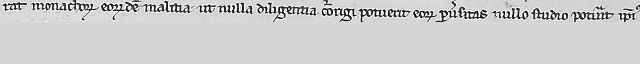

rat monachorum eorundem malitia ut nulla diligentia corrigi potuerit eorum perversitas nullo studio potuerit ipsius
rat monachlorum eorundem malitia ut nulla diligentia corrgi potuerit eorum perversitas nullo suudio potuerit ipsius



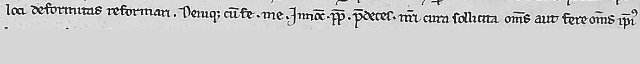

loci deformitas reformari Denique cum felicis memorie Innocentii pape predecessoris nostri cura sollicita omnes aut fere omnes ipsius
loci deformitas reformari Denque cum feis moe Jnoce pap predeces nostri cura sollicita omnes aut fere omes ipsius



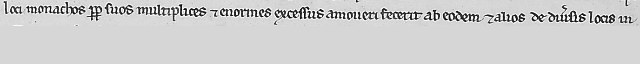

loci monachos propter suos multiplices et enormes excessus amoveri fecerit ab eodem et alios de diversis locis in
loci monachos peoper suos multiplices et enormes excessus amoveri fecerit ab eodem et alios de diversis locis in



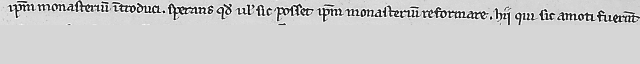

ipsum monasterium introduci speratis quod vel sic posset ipsum monasterium reformare hij qui sic amoti fuerant
ipsum monasterium introduci sperats quod vel sic posset ipsum monasterium reformare halna qui sic amoti fuerunt



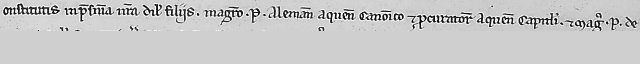

onstitutis in presentia nostra dilectis filijs magistro P Alemano Aquensi Canonico et procuratore Aquensis Capituli et Magistro P de
onstitutis in presona nostra dilecti filijs magistro P Alenani a quensem Canonico et procuratioris a quensim Capitli et Mais pro de



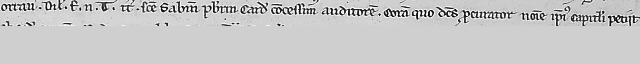

orrau Dilectum fratrem nostrum T tituli sancte Sabine presbiterum Cardinalem concessimus auditorem Coram quo dictus procurator nomine ipsius Capituli petijt
orrais niscte fratrem nostrm eterm tituli sancte Sabine presbiberum Cardneme concessimus auditorem coram quo dictus procurator norie ipsius caputli petit



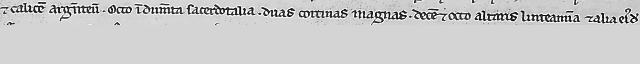

et calicem argenteum Octo indumenta sacerdotalia duas cortinas magnas decem et octo altaris linteamina et alia eiusdem
et calicem argentensius octo indumenta sacerdotalia duas cortinas magnas deceet octo altaris lintemmiam et alia esus



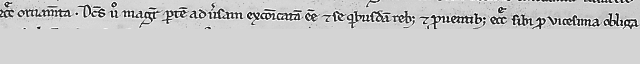

ecclesie ornamenta Dictus vero magister partem adversam excommunicatam esse et se quibusdam rebus et proventibus ecclesie sibi pro vicesima obliga
clesia orvamenta Dictus viro magiter partem ad vesam excommunicatam esse et se quibusdam rebus et proventibus ecclesie sibi pro vicesima obliga



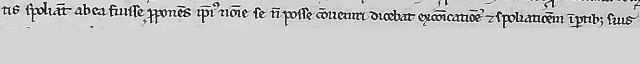

tis spoliant ab ea fuisse proponens ipsius nomine se non posse conveniri dicebat excommunicationem et spoliationem in partibus suis
tis spoliant ab ea fuisse proponens ipsius nomie se non posse conveniri dicebat excomunicatione et spoliationem in partibus suis



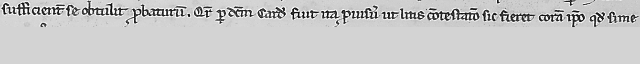

sufficienter se obtulit probaturum Quare per dictum Cardinalem fuit ita provisum ut litis contestatio sic fieret coram ipso quod si me
sufficienter se obtulit probaturum Qater per dictum Cardinal fuit ita provisum ut litis contestato sicut fieret coram ipso quod sime



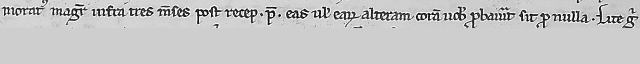

moratus magister infra tres menses post receptionem presentium eas vel earum alteram coram vobis probaverit sit pro nulla Lite igitur
moratus magister infra tres nensees post recepe presentius eas vebl earum alteram coram vobis probaverit sit pro nlla Lite erguo



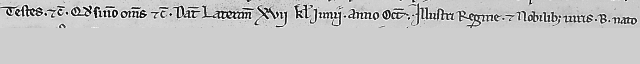

Testes etcetera Quod sinon omnes etcetera Datum Laterani XVij Kalendas Junij Anno Octavo Illustri Regine et Nobilibus viris B nato
Testes etcetera Quod suvon omnes etcetera Datum Laterani XVij Kalendas Jnij Anno Onct Jlustri Regine et Nobilibus iuris sed nato



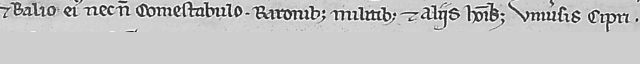

et Balio eius necnon Comestabulo Baronibus militbus et alijs hominibus Universis Cipri
et Balio eius nec non Comestabulo Baronibus militibus et Alijs honibus Universis Cipri



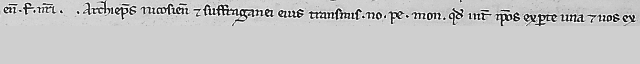

Venerabiles fratres nostri Archiepiscopus Nicosiensis et suffraganei eius transmissa nobis petitione monstrarunt quod inter ipsos ex parte una et vos ex
enslem fratrn nostri Archiepiscopus nicosiensis et suffraganer eis transmis no pe mon quod inter ipsos ex parte una et vos ex



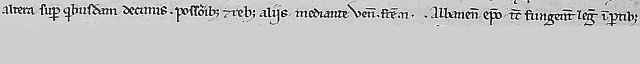

altera super quibusdam decimis possessionius et rebus alijs mediante Venerabili fratre nostro Albanensi episcopo tunc fungente legatione in partibus
altera super quibusdam decimis possesoibus et rebus alijs mediante erabile fratren Albanensis episcopo tunc sungenter iegutur in partibus



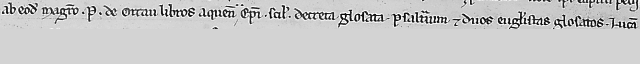

ab eodem Magistro P de Orrau libros Aquensis Episcopi scilicet decreta glosata psalterrium et duo evangelistas glosatos Lucam
ab eodem magistro P de orravi libros a quensiem Episcopi saleis dectreta glosata prosalimum et duos euglistas Nlosatos nica



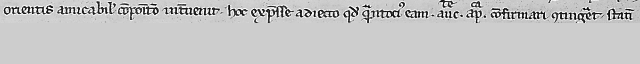

orientis amicabiliter compositio intervenit hoc expresse adiecto quod quantocius eam auctoritate apostolica confirmari contingeret statim
orientis amicabilis compositio intruenit hoc expresse adiecto quod quintocius eam auctoritate apostolica confirmari contingeret statum



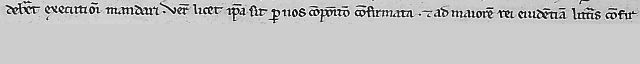

deberet executioni mandari Verum licet ipsa sit per vos composotio confirmata et ad maiorem rei evidentiam litteris confir
debernt executioni mandari Veetum licet ipsa sit per vos compositio confirmata et ad maiorem rei evidetiam litteris confimationis



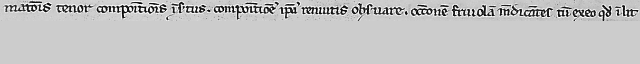

mationis tenor compositionis insertus compositionem ipsam renuitis observare occasionem frivolam mendicantes tum exeo quod in lit
mationis tenor compositionis onstus compositione ipsa renutis observare occtatonem fruvolam nondicantes tum exea quod inlit



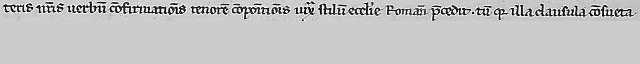

teris nostris verbum confirmationis tenorem compositionis iuxta stilum ecclesie Romane precedit tum quia illa clausula consueta
teris nostris verbum confirivationis tenorem compositionis iuxta stilum ecclesie Romani precedit tum quod illaclausula consueta



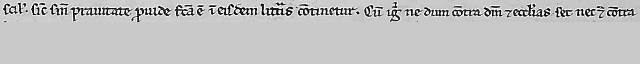

scilicet sicut sine pravitate provide facta est in eisdem litteris continetur Cum igitur ne dum contra deum et ecclesias set nec etiam contra
scilis sicut siten pravitate provide facta est in eisdem litteris continetur Cum igitur ne dum contra deum et ecclesias set nec et contra



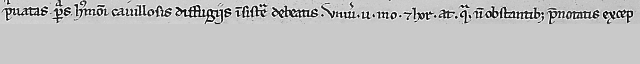

privatas personas huiusmodi cavillosis diffugijs insistere debeatis Universitatem vestram monemus et hortamur attente quatinus nonobstantibus prenotatis excep
prevatas peris huiusmodi cavillosis difugijs insistere debeatis Uniram vestram monmo et hor aet quatie non obstantibus prenotatis excep



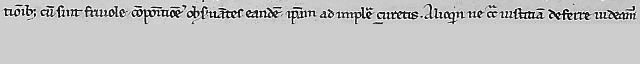

tionibus cum sint frivole compositionem observantes eandem ipsam ad implere curetis Alioquin ne circa iustitiam deferre videamur
tionibus cum sint fruvole compositione observates eandem ipsam ad imple turetis Alioquin ne circa iustitiam deferre videamur



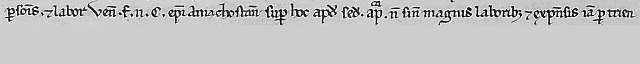

personis et labor Venerabilis fratris nostri C episcopi Amachostani super hoc apud sedem apostolicam non sine magnis laboribus et expensis iam per trien
persois et labor Venerabilimfrte nostr aie episcopi machostani super hoc apud sede apostolica non sipen magnis laboribus et x pretensis iam per tren



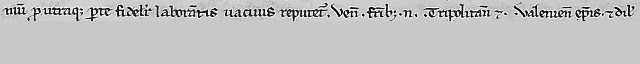

nium pro utraque parte fideliter laborantis vacuus reputerur Venerabilibus fratribus nostris Tripolitano et Valeniensi episcopis et dilecto
nuum pro utraque parte fideliter laborantis vacuus reputetur Veneabili fratrius nostr Cripolitani et Valeniensem episcopis et dilectus



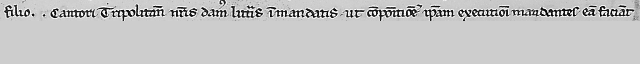

filio Cantori Tripolitano nostris damus litteris in mandatis ut compositionem ipsam executioni mandantes eam faciant
filio. Cautori Tripolitani nostris damus litteris in mandatis ut compositione ipsam executioni mandantes eam ficiant



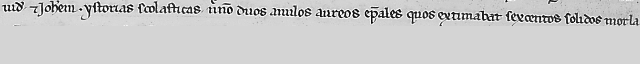

videlicet et Johannem ystorias scolasticas necnon duos anulos aureos episcopales quos extimabat sexcentos solidos morla
vudl et hohem rstorias scolasticas non non duos amilos aureos episcopales quos extimabat sexcentos solidos morla



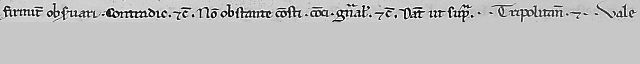

firmiter observari Contradictores etcetera Non obstante constitutione concilii generali etcetera Datum ut supra Tripolitano et Vale
firmiter observari contradio etcetera. No obstante constia concis grntialis etcetera Datum ut supra Trepolitani et Vale



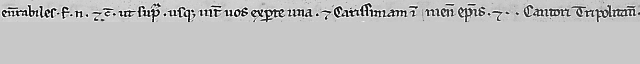

enerabiles fratres nostri etcetera ut supra usque inter vos ex parte una et Carissimam in niensi episcopis et Cantori Tripolitano
enerabiles fraterm nostrs et cetera ut supra usque inter vos ex parte una et Carissimam in miense episcopis et Cantori Tripolitani



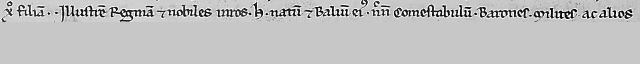

Christo filiam Illustrem Reginam et nobiles viros H natum et Balium eius necnon Comestabulum Barones Milites ac alios
Cristo filiam Nlustrem Regnam et nobiles viros He natum et Balium eius iat no Conestabulum Barones Milites ac alios



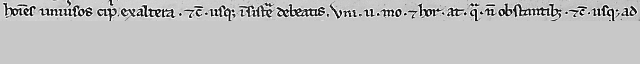

homines universos cipri ex altera etcetera usque insistere debeatis debeatis Universitatem vestram monemus et hortamur attente quatinus non obstantibus etcetera usque ad
homines unniversos cupra exaltera etcetera usque insistere debeatis Unteriam vestram monemos et horamu aenti quainus non obstantibus etcetera usque ad



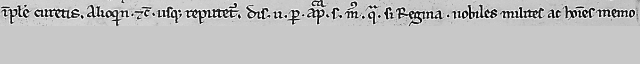

implere curetis Alioquin etcetera usque reputetur discretioni vestre per apostolica scripta mandamus quatinus si Regina nobiles milites ac homines memo
im ple curetis Alioquin etcetera usque reputetur discrtoni vestre per apostolica scripta mandamus quatinus s Regina nobiles milites ac homines memo



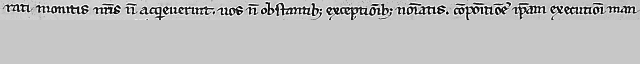

rati monitis nostris non acquieverunt vos non obstantibus exceptionibus nominatis compositionem ipsam executioni man
rati monitis nostris non acqueverint vos non obstantibus exceptionibus nominatis compositionem ipsam executioni man



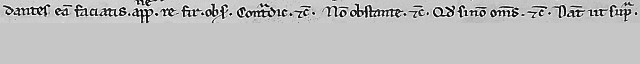

dantes eam faciatis appellatione remota firmiter observare Contradictores etcetera Non obstante etcetera Quod sinon omnes etcetera Datum ut supra
dantes eam faciatis apppellatione remota fifirer obserarir Contrdicis et cetera non obstante etcetera Quod si nnomnes etcetera Datum ut supra



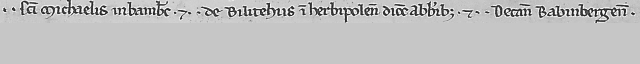

sancti Michaelis in bamberc et de Bilitehiis in herbipolensi diocesi Abbatibus et Decano Babinbergensi
 sancti Michaelis inbamberem et de Silitehus in herbipolensis diocesis abbatibus et Decano Rabunbergensis



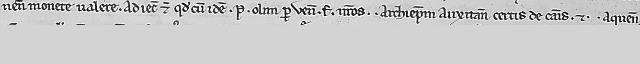

nensis monete valere adiecit etiam quod cum idem P olim per Venerabiles fratres nostros Archiepiscopum Auxitanum certis de causis et Aquensem
nensi monete valere adiest et qud cuum idem Polim per erabilem fratra nostros Archiepiscopum Auxitani certis de causs et Auenimum



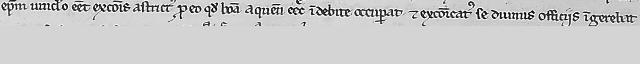

episcopum vinculo esset excommunicationis astrictus pro eo quod bona Aquensis ecclesie indebite occuparat et excommunicatus se divinis officijs ingerebat
episcopum inclo esset excomunicationi astricitus pro eo quod bona a quensim ecclesie indebite occuperat et excommunicatus se divmis officijs ingerebat



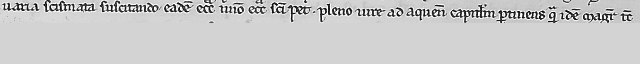

varia scismata suscitando eadem ecclesia necnon ecclesia sancti Petri pleno iure ad Aquensem capitulum pertinens quam idem Magister tunc
varia scismata suscitando eadem ecclesie in vo ecclesie sancti peti pleno iure ad aquensem capulum partinenis que idem Magister turc



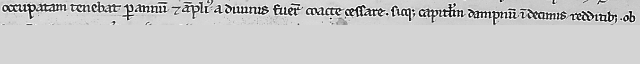

occupatam tenebat per annum et amplius a divinis fuerit coacte cessare sicque capitulum dampnum in decimis redditibus ob
occupatam tenebat perannum et aptosoulus a divinis fuerit coacte cessare sique caputulum dampnum in decimis reditibus ob



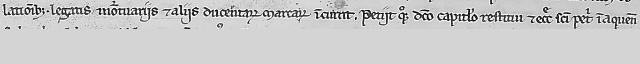

lationibus legatis mortuarijs et alijs ducentarum Marcarum incurrit Petijt quoque dicto capitulo restitui et ecclesie sancti Petri in Aquensi
lationibus legatis montuarijs et aijs dugesitarum Marcarum incurint petijt quoue dicto caputulo restitui et cclia sancti pet in a quensus



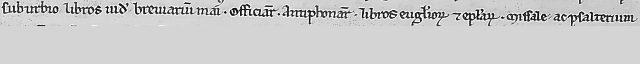

suburbio libros videlicet breviarium maius Officiarium Antiphonarium libros evangeliorum et epistolarum Missale ac psalterium
suburbio libros vid brevarium mais officiant Antphonant libros eugeliorum et eplarum Missale ac prosalterium



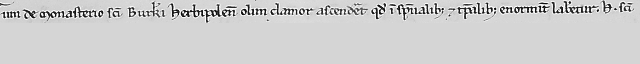

um de Monasterio sancti Burkardi Herbipolensis olim clamor ascenderet quod in spiritualibus et temporalibus enormiter laberetur H sancti
tum de Monasterio Sancti Burbliam Herhiplensis olim clamor ascendet quod in spiritualibus et temporalibus enormiter labetur hed sanct



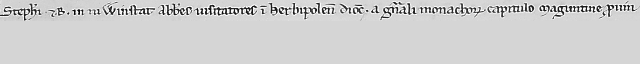

Stephani et B in in Winstat Abbates visitatores in Herbipolensi diocesi a generali monachorum capitulo Maguntine provin
Stephai et ceram manm mo Mwustat Abbate insitatores in herhipolensis diocesis a grentiali monachorum capitulo Maguntine proum



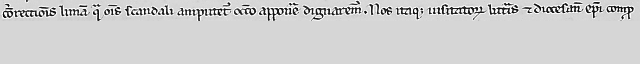

correctionis limamqua omnis scandali amputetur occasio apponere dignaremur Nos itaque visitatorum litteris et diocesani episcopi compro
correctionis linam que omtius scandali amputetur octo apponere dignaremur Nos itaque visitatorum litteris et diocesani episcopi compr



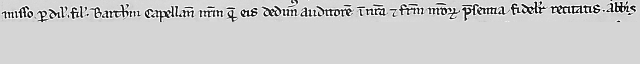

misso per dilectum filium Bartholomeum Cappellanum nostrum quem eis dedimus auditorem in nostra et fratrum nostrorum presentia fideliter recitatis Abbatis
misso per dilectu filius Barthum Capellani nostrum quem eis dedimus auditorem in nostra et fratrem nostrorum presentia fideliter recitatis abbatis



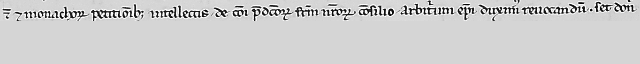

etiam et monachorum petitionibus intellectis de communi predictorum fratrum nostrorum consilio arbitrium episcopi duximus revocandum set donec
et et monachorum petitionibus intellectis de comni predictorum fratrum nostrorum consilio Arbiterum episcopi duximus revocandum set done



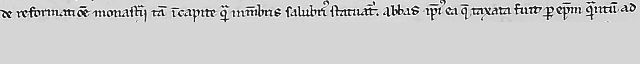

de reformatione monasterij tam in capite quam in membris salubriuus Abbas ipsius ea que taxata fuit per episcopum quantum ad
de reformatione monasti tam in capite quam mmbris salubius statuatur abbas ipsius ea que taxata fuit per episcopum quaintum ad



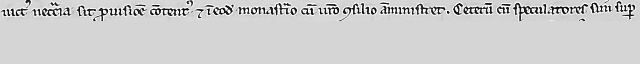

victus neccessaria sit provisione contentus et in eodem monasterio cum vestro consilio amministret Ceterum cum speculatores simus super
victus necleria sit provisione contentus et in eodm monasterio cum vestro consilio amministret Ceterum cum specularores sum super



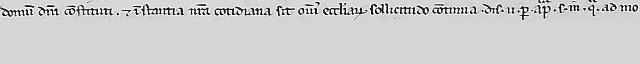

domum domini constituti et in stantia nostra cotidiana sit omnium ecclesiarum sollicitudo continua discretioni vestre per apostolica scripta mandamus quatinus ad mo
domum domini constituti et instantia nostra cotidiana sit omninus ecclesiarum sollicitudo continia discretioni vestre per apostolica scripta mandums quatnus ad mo



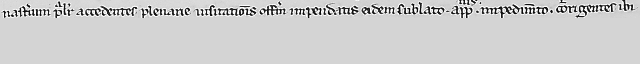

nasterium personaliter accedentes plenarie visitationis officium impendatis eidem sublato appellationis impedimento corrigentes ibi
nastrum preler accedentes plenare isitationis offum impendatis eidem sublato appepellatione mpedimento corrigentes ibi



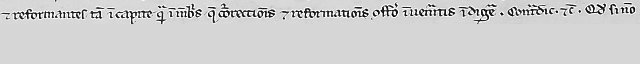

et reformantes tam in capite quam in membris que correctionis et reformationis officio inveneritis indigere Contradictores etcetera Quod si non
et reformantes tam in capte quam in mebis que correctionis et reformationis offo in venentis indigere Contdicis etcetera Quod si non



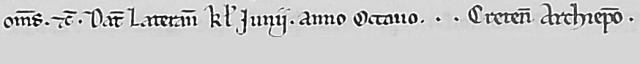

omnes etcetera Datum Laterani Kalendas Junij Anno Octavo Cretensi Archiepiscopo
omnes etcetera Datum Laterani Kaldannas Iunij Anno Octavo Cretensis Archiepiscopo



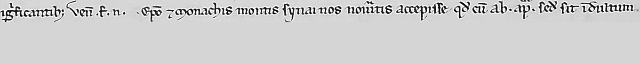

ignificantibus Venerabili fratre nostro Episcopo et Monachis montis synai nos noveritis accepisse quod cum ab apostolica sede sit indultum
ognficantibus Verbilem fratrem nostrum Episcopo et Monachis montis sima nos novertis accepisse quod cum ab apostolice sedes sit indultum



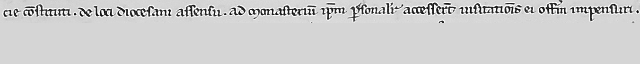

cie constituti de loci diocesani assensu ad Monasterium ipsum personaliter accesserunt visitationis ei officium impensuri
ce constituti de loci diocesam assensu ad Monasterium ipsum personaliter accessernt visitationis ei offum impensuri



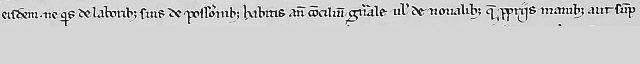

eisdem ne quis de laboribus suis de possessionibus habitis ante concilium generale vel de novalibus que proprijs manibus aut sump
eisdem ne quid de laboribus suis de possionibus habitis ante concilium grntale vel de novalibus que proprijs manibus autr supr



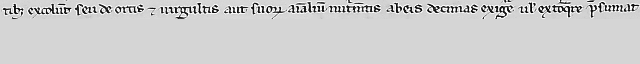

tibus excolunt seu de ortis et virgultis aut suorum animalium nutrimentis ab eis decimas exigere vel extorquere presumat
tibus excocolunt seu de ortis et irgultis aut suorum animalium niitseremntis ab eis decimas exigere vel extonquere presumat



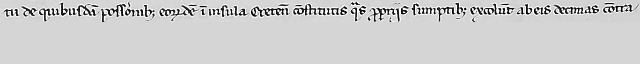

tu de quibusdam possessionibus eorundem in insula Cretensi constitutis quas proprijs sumptibus excolunt ab eis decimas contra
tu de quibusdam possonibus eorundem in ninsula Gretensis constitutis quis proprijs sumptibus excoolunt ab eis decimas contra



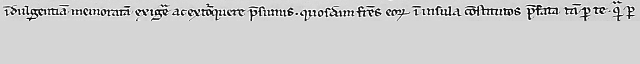

indulgentiam memoratam exigere ac extorquere presumis quosdam fratres eorum in insula constitutos prefata tam per te quam per
indulgentiam memoratam ex igere ac ex tnonquere presumus quosam fratres eorum in insula constitutos prefata tanm per te quas per



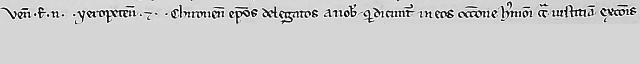

Venerabiles fratres nostros Yeropetenssem et Chironensem episcopos delegatos a nobis qui dicuntur in eos occasione huiusmodi circa iustitiam excommunicationis
eVerabiem fratem nostrum Beropetensis et Chhironensem episcopos delegatos a nobis qui dicuntur in eos occmatone huiusmodi cirtaiustitiam excomuninicationis



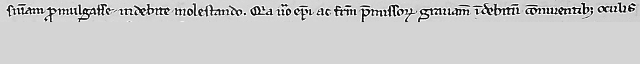

sententiam promulgasse indebite molestando Quia vero episcopi ac fratrum premissorum gravamen indebitum conviventibus oculis
sententiam promulgasse indebite molestando Ma vero episcopi ac fratrm premissorum gravamun indebitum commventibus oculis



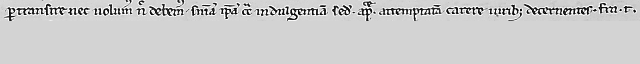

pertransire nec volumus nec debemus sententiam ipsam circa indulgentiam sedis apostolice attemptatam carere iuribus decernentes fraternitati tue
pertransire nec volumus noc debemur sententiam ipsa eirtua indulgentiam sedes apostolica attemptatam carere iuribus decernentes fratrn titit



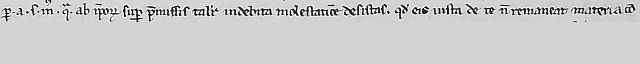

per apostolica scripta mandamus quatinus ab ipsorum super premissis taliter indebita molestatione desistas quod eis iusta de te non remaneat materia con
pe apostolca ripta mandamus quatinu ab ipsorum super premissis taliter indebita molestatione desistas quod eis iusta de te non remaneat materia con



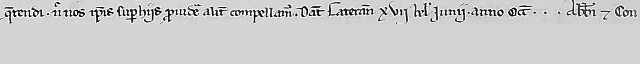

querendi nec nos ipsis super hijs providere aliter compellamur Datum Laterani XVij Junij Anno Octavo Abbati et Con
querendi noc nos ipsis superhijs provide aliter compellamur Datum Laterani XVIj Kalendas Junij anno Oct Abbati et Con



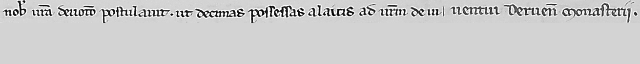

 nobis vestra devotio postulavit ut decimas possessas a laicis ad vestrum de iu ventui Deruensis Monasterij
nobis vestra devoriom postulavit ut decimas possessas alautis ad vestrum de vi ventui dervensis Monasterij



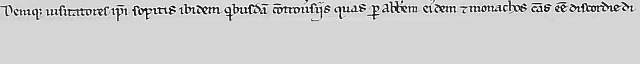

Denique visitatores ipsi sopitis ibidem quibusdam controversijs quas per Abbatem eiusdem et monachos causas esse discordie di
Denique visitatores ipsi sopitis ibidem quib usdam controversijs quas per abbatem eiusdem etm monachos causs esse discordiedi



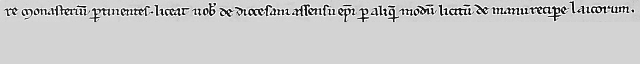

re Monasterium pertinentes liceat vobis de diocesani assensu episcopo per aliquem modum licitum de manu recipere laicorum
re Monasterium pertinentes liceat vobis de diocesam assensu episcopi per aliquam modum licitum de manurecipere laicorum



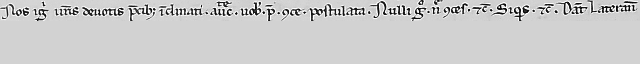

Nos igitur vestris devotis precibus inclinati auctoritate vobis presentium concedimus postulata Nulli ergo nostre concessionis etcetera Siquis etcetera Datum Laterani
Nos igitur vestris devotis precibus inclinati auctoritate vobisprerentis oncetis postulata Nulli ergo nosto ocssisi et cetera Siquis etcetera Datum Laterani



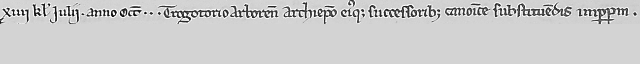

Xiiij Kalendas Julij Anno Octavo Trogotorio Arborensi Archiepiscopo eiusque successoribus canonice substituendis imperpetuum
xiij Kalendas Julij Anno Ocesi TAnrgotorio Arhborensis Archiepiscopo eiusque successoribus canonice substituendis imperperum



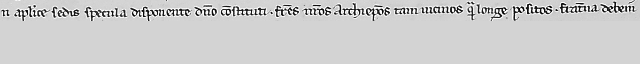

n apostolice sedis specula disponente domino constituti fratres nostros Archiepiscopos tam vicinos quam longe positos fraterna debemus
in apostolice sedis specula disponente domino constituti fratres nostros Archiepiscopos tam vicinos qua longe positos fratuna debemus



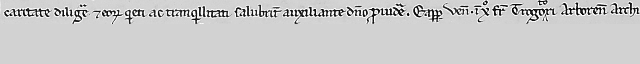

caritate diligere et eorum quieti ac tranquillitati salubriter auxiliante domino providere Eapropter venerabilis in Christo frater Trogotori Arborensis Archi
caritate diligere et eorum quieti ac tranquilitati salubriter auxiliante dmino providere Eapre Venrabilem ihristo frater Tirgorri Arborensis Archi



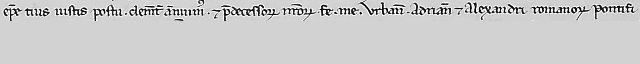

episcope tuis iustis postulationibus clementer annuimus et predecessorum nostrorum felicis memorie Urbani Adriani et Alexandri romanorum Pontifi
episcope tuis iustis postu clenent ammuimus et predecessorum nostrorum fe me UVUbhani Adnanis et Alexandri reomanorum pontifi



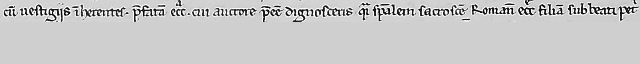

cum vestigijs inherentes prefatam ecclesiam cui auctore preesse dignosceris quasi specialem sacrosancte Romane ecclesie filiam sub beati Petri
cum vestigijs inherentes prefatam ecclesie cui auctore pre dignosceris quasi specialem sacrosane Ronane ecclesia filiam subbeati petri



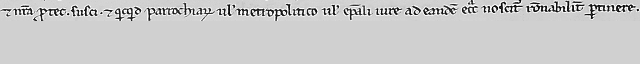

et nostra protectione suscipimus et quicquid parrochiarum vel metropolitico vel episcopali iure ad eandem ecclesiam noscitur rationabiliter pertiner
et nostra protecte susci et quiquid parrochiarum vel metropolinico vel episcopali ire ad eandem ecclesia noscitur tonabiliter pertinere



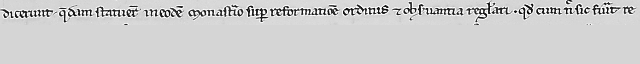

dicerunt quedam statuerunt in eodem Monasterio super reformatione orditus et observantia regulari quod cum nec sic fuerit re
dicerunt quedam statuenit in eodem monasterio supereformatione ordinis et observantia regulari quod cum non sic fuerit re



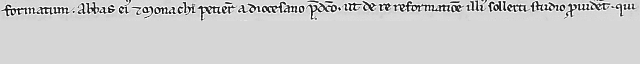

formatum Abbas eius et Monachi petierunt a diocesano predicto ut de re reformatione illius sollerti studio provideret qui
formatum Abbas eius et Monachi petierit a diocesano predicto ut de re reformatione illis sollerti studio providet qui



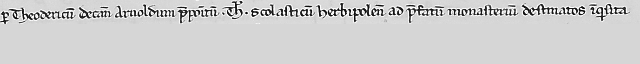

per Theodoricum Decanum Arnoldum prepositum Th Scolasticum herbipolensis ad prefatum monasterium destinatos inquisita
per Theodericum decani Arvoldum prepositum Thu Scolasticum herbipolensis ad prefatum monasterium destimatos inquisita



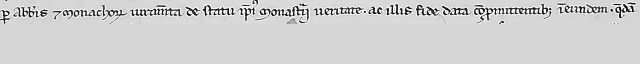

per Abbatis et monachorum iuramenta de statu ipsius Monasterij veritate ac illis fide data compromittentibus ineundem quedam
per Abbatis et Monachorum iuramenta de statu ipsius Monastrij veritate ac illis fide data compimittentibus in eundem quedam



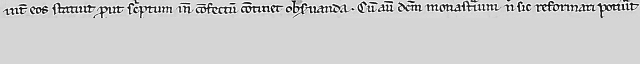

inter eos statuit prout scriptum inde confectum continet observanda Cum autem dictum monasterium neca sic reformari potuerit
inter eos statuit prout scriptum nan confectum continet observanda Cum auem dictum monasterium non sic reformari poturit



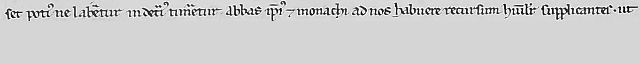

set potius ne laberetur in deterius timeretur Abbas ipsius et monachi ad nos habuere recursum humiliter supplicantes ut
set potius ne laberetur in detius tuneretur abbas ipsius et monachi ad nos habuere recursum humiliter supplicantes ut


In [ ]:
start_time = time.time()

# load the checkpoint of the best epoch
best_checkpoint_path = os.path.join(output_path, "checkpoint_model." + str(best_epoch) + ".hdf5")
htr_model.load_checkpoint(target=best_checkpoint_path)

# predict() function will return the predicts with the probabilities
predicts, prob = htr_model.predict(x=dataset.test_data_generator,
                                   steps=1,
                                   ctc_decode=True,
                                   verbose=1,
                                   use_multiprocessing=False)

print("--- %s seconds ---" % (time.time() - start_time))

predicts = tf.sparse.to_dense(predicts[0]).numpy()
prob = prob.numpy()

# decode to string
predicts = [dataset.tokenizer.decode(x) for x in predicts]
ground_truth = [x.decode() for x in dataset.test_data_generator.labels]

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
print(len(predicts), len(ground_truth), len(prob))

evaluate = evaluation.ocr_metrics(predicts,
                                  ground_truth,
                                  norm_accentuation=True,
                                  norm_punctuation=True)

e_corpus = "\n".join([
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

from backend.ocr_service.image_processing import adjust_to_see

for j, item in enumerate(dataset.test_data_generator.samples):
    print("=" * 256, "\n")
    cv2_imshow(adjust_to_see(item))
    print(ground_truth[j])
    print(predicts[j])
   